In [1]:
import sys
sys.path.append('./ISMIR2020_U_Nets_SVS/')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import json
import os
import string
import random
import warnings
import glob
import h5py
import math
import gc
import cv2
from IPython.display import display, Audio
from tqdm import tqdm
from typing import TYPE_CHECKING, Any, Callable, Optional
from sklearn.model_selection import StratifiedKFold, KFold

import albumentations as al
from albumentations.pytorch.transforms import ToTensorV2, ToTensor
from albumentations.core.transforms_interface import BasicTransform, ImageOnlyTransform

import librosa
import wave
import pyaudio
from librosa.display import waveshow, specshow
from librosa.feature import melspectrogram, mfcc

from viphoneme import vi2IPA_split, syms
from sortedcontainers import SortedList


import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.functional import F
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau, _LRScheduler
from torch.optim import AdamW, SGD

from ISMIR2020_U_Nets_SVS.source_separation.models.tfc_tdf_net import TFC_TDF_NET_Framework

warnings.filterwarnings('ignore')
%matplotlib widget

# singing voice separation 

In [2]:
args = {}

# FFT params
args['target_name'] = 'vocals'
args['n_fft'] = 4096
args['hop_length'] = 1024
args['num_frame'] = 128

# SVS Framework
args['spec_type'] = 'complex'
args['spec_est_mode'] = 'mapping'

# Other Hyperparams
args['optimizer'] = 'adam'
args['lr'] = 0.001
args['dev_mode'] = False
args['train_loss'] = 'spec_mse'
args['val_loss'] = 'raw_l1'
args['layer_level_init_weight'] = False
args['unfreeze_stft_from'] = -1

# DenseNet Hyperparams

args ['n_blocks'] = 9
args ['input_channels'] = 4
args ['internal_channels'] = 24
args ['first_conv_activation'] = 'relu'
args ['last_activation'] = 'identity'
args ['t_down_layers'] = None
args ['f_down_layers'] = None
args ['tif_init_mode'] = None

# TFC_TDF Block's Hyperparams
args['n_internal_layers'] =5
args['kernel_size_t'] = 3
args['kernel_size_f'] = 3
args['tfc_tdf_activation'] = 'relu'
args['bn_factor'] = 16
args['min_bn_units'] = 16
args['tfc_tdf_bias'] = True

# Path

In [3]:
train_label_path = './train/labels/'
train_audio_path = './train/songs/'
train_clean_path = './train/song_clean/'
test_lyric_path = './public_test/lyrics/'
test_audio_path = './public_test/songs/'
test_clean_path = './test_clean/'
private_lyric_path = './private_test/sample_labels/'
private_audio_path = './private_test/songs/'
private_clean_path = './private_clean/'

sample_rate = 44100
phone2int = {v: i for i, v in enumerate(syms)}

vn_string = 'aàáảãạăằắẳẵặâầấẩẫậbcdđeèéẻẽẹêềếểễệghiìíỉĩịlkmnoòóỏõọôồốổỗộơờớởỡợpqrstuùúủũụưừứửữựvxyỳýỷỹỵ'
vn_dict =  {vn_string[i]: i for i in range(len(vn_string))}

melSpecConfig = {'n_mels': 128, 'n_fft': 512} 
mfccConfig = {"n_mfcc": 13, "melkwargs": {"n_fft": 400, "hop_length": 160, "n_mels": 23, "center": False}}
delimit = '/'
kfold = 10
seed = 15

# Function

In [4]:
def labelTransfer(json_path):
    delimit = '/'
    with open(json_path, 'r', encoding='utf-8') as f:
        file = json.load(f)
    fileList, list_length_text = [], []
    for row in file:
        list_word = row['l']
        for word in list_word:
            word['word_duration'] = word['e'] - word['s']
            word['phoneme'] = vi2IPA_split(word['d'], delimit=delimit).split(delimit)[1:-3]
            fileList.append(word)
            list_length_text.append(len(word['d'].split(' ')))
    
    return pd.Series([fileList, np.max(list_length_text)])


def load(path, sr=sample_rate, mono=True, offset=0., duration=None):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        y, curr_sr = librosa.load(path, sr=sr, mono=mono, res_type='kaiser_fast', offset=offset, duration=duration)

    if len(y.shape) == 1:
        y = y[np.newaxis, :] # (channel, sample)

    return y, curr_sr


def g2p_vn(word):
    return vi2IPA_split(word, delimit=delimit).split(delimit)[1:-3]


def phone2seq(text):
    seq = []
    for c in text:
        if c in syms:
            idx = phone2int[c]
            seq.append(idx)
    return np.array(seq)



class AudioTransform(BasicTransform):
    """Transform for Audio task"""

    @property
    def targets(self):
        return {"data": self.apply}

    def update_params(self, params, **kwargs):
        if hasattr(self, "interpolation"):
            params["interpolation"] = self.interpolation
        if hasattr(self, "fill_value"):
            params["fill_value"] = self.fill_value
        return params


class AddGaussianNoise(AudioTransform):
    """Shifting time axis"""

    def __init__(self, min_amplitude=0.0001, max_amplitude=0.0015, always_apply=False, p=0.5):
        super(AddGaussianNoise, self).__init__(always_apply, p)

        self.min_amplitude = min_amplitude
        self.max_amplitude = max_amplitude

    def apply(self, data, **params):
        noise = np.random.randn(len(data))
        data_wn = data + random.uniform(self.min_amplitude, self.max_amplitude) * noise

        return data_wn


class TimeShifting(AudioTransform):
    """ Do time shifting of audio """

    def __init__(self, fraction=0.5, always_apply=False, p=0.5):
        super(TimeShifting, self).__init__(always_apply, p)

        self.fraction = fraction
        assert self.fraction > 0

    def apply(self, data, **params):
        """
        data : ndarray of audio timeseries
        """
        num_place_to_shift = int(random.uniform(-self.fraction, self.fraction) * len(data))
        data_shift = np.roll(data, num_place_to_shift)
        if num_place_to_shift > 0:
            data_shift[:num_place_to_shift] = 0
        else:
            data_shift[num_place_to_shift:] = 0

        return data_shift


class SpeedTuning(AudioTransform):
    """ Do speed Tuning of audio """

    def __init__(self, always_apply=False, p=0.5, speed_rate=None):
        """
        Give Rate between (0.5,1.5) for best results
        """
        super(SpeedTuning, self).__init__(always_apply, p)

        if speed_rate:
            self.speed_rate = speed_rate
        else:
            self.speed_rate = np.random.uniform(0.6, 1.3)

    def apply(self, data, **params):
        """
        data : ndarray of audio timeseries
        """
        audio_speed_tune = cv2.resize(data, (1, int(len(data) * self.speed_rate))).squeeze()
        if len(audio_speed_tune) < len(data):
            pad_len = len(data) - len(audio_speed_tune)
            audio_speed_tune = np.r_[np.random.uniform(-0.001, 0.001, int(pad_len / 2)),
                                     audio_speed_tune,
                                     np.random.uniform(-0.001, 0.001, int(np.ceil(pad_len / 2)))]
        else:
            cut_len = len(audio_speed_tune) - len(data)
            audio_speed_tune = audio_speed_tune[int(cut_len / 2):int(cut_len / 2) + len(data)]

        return audio_speed_tune


class StretchAudio(AudioTransform):
    """ Do stretching of audio file"""

    def __init__(self, always_apply=False, p=0.5, rate=None):
        super(StretchAudio, self).__init__(always_apply, p)

        if rate:
            self.rate = rate
        else:
            self.rate = np.random.uniform(0.5, 1.5)

    def apply(self, data, **params):
        """
        data : ndarray of audio timeseries
        """
        input_length = len(data)

        data = librosa.effects.time_stretch(data, self.rate)

        if len(data) > input_length:
            data = data[:input_length]
        else:
            data = np.pad(data, (0, max(0, input_length - len(data))), "constant")

        return data


class PitchShift(AudioTransform):
    """ Do time shifting of audio """

    def __init__(self, always_apply=False, p=0.5, n_steps=None):
        super(PitchShift, self).__init__(always_apply, p)
        '''
        nsteps here is equal to number of semitones
        '''

        self.n_steps = n_steps

    def apply(self, data, **params):
        """
        data : ndarray of audio timeseries
        """
        return librosa.effects.pitch_shift(data, sr=SR, n_steps=self.n_steps)


class AddCustomNoise(AudioTransform):
    """
    This Function allows you to add noise from any custom file you want just give path to the directory where the files
    are stored and you are good to go.
    """

    def __init__(self, file_dir, always_apply=False, p=0.5):
        super(AddCustomNoise, self).__init__(always_apply, p)
        '''
        file_dir must be of form '.../input/.../something'
        '''

        self.noise_files = glob(file_dir + '/*')

    def apply(self, data, **params):
        """
        data : ndarray of audio timeseries
        """
        nf = random.choice(self.noise_files)

        noise, _ = librosa.load(nf, sr=SR, duration=PERIOD)

        if len(noise) > len(data):
            start_ = np.random.randint(len(noise) - len(data))
            noise = noise[start_: start_ + len(data)]
        else:
            noise = np.pad(noise, (0, len(data) - len(noise)), "constant")

        data_wn = data + noise

        return data_wn


class PolarityInversion(AudioTransform):
    def __init__(self, always_apply=False, p=0.5):
        super(PolarityInversion, self).__init__(always_apply, p)

    def apply(self, data, **params):
        """
        data : ndarray of audio timeseries
        """
        return -data


class Gain(AudioTransform):
    """
    Multiply the audio by a random amplitude factor to reduce or increase the volume. This
    technique can help a model become somewhat invariant to the overall gain of the input audio.
    """

    def __init__(self, min_gain_in_db=-12, max_gain_in_db=12, always_apply=False, p=0.5):
        super(Gain, self).__init__(always_apply, p)
        assert min_gain_in_db <= max_gain_in_db
        self.min_gain_in_db = min_gain_in_db
        self.max_gain_in_db = max_gain_in_db

    def apply(self, data, **args):
        amplitude_ratio = 10 ** (random.uniform(self.min_gain_in_db, self.max_gain_in_db) / 20)
        return data * amplitude_ratio


class CutOut(AudioTransform):
    def __init__(self, always_apply=False, p=0.5):
        super(CutOut, self).__init__(always_apply, p)

    def apply(self, data, **params):
        """
        data : ndarray of audio timeseries
        """
        start_ = np.random.randint(0, len(data))
        end_ = np.random.randint(start_, len(data))

        data[start_:end_] = 0

        return data


def durationCal(path, sr=16000):
    y = librosa.load(path, sr=sr)[0]
    return float(librosa.get_duration(y))


def mono_to_color(X, eps=1e-6, mean=None, std=None):
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)

    _min, _max = X.min(), X.max()

    if (_max - _min) > eps:
        V = np.clip(X, _min, _max)
        V = 255 * (V - _min) / (_max - _min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(X, dtype=np.uint8)

    return 


def seperateData(df, save_folder, model):
    os.makedirs(save_folder, exist_ok=True)
    for _, row in tqdm(df.iterrows(), leave=True):
        name, path = row.fileName, row.audioPath
        y = librosa.load(path, sr=44100, mono=False)[0]
        if len(y.shape)!=2:
            y = np.array([y, y])
        model.separate_track(y.T, f'{os.path.join(save_folder, name)}.wav')

In [5]:
# singing voice seperate model
# seperate_model = TFC_TDF_NET_Framework(**args)
# seperate_model = seperate_model.load_from_checkpoint('./ISMIR2020_U_Nets_SVS/etc/checkpoints/tfc_tdf_net/debug_large/vocals_epoch=2007.ckpt')

In [6]:
# seperateData(df, train_clean_path, seperate_model)

In [7]:
# %%time
# kf = KFold(n_splits=kfold, random_state=seed, shuffle=True)
# list_label = glob.glob(f'{train_label_path}*.json')
# list_audio = glob.glob(f'{train_audio_path}*.wav')
# list_clean = glob.glob(f'{train_clean_path}*.wav')
# list_name = [i.split('\\')[-1].replace('.wav', '') for i in list_audio]
# print(f'label: {len(list_label)}, audio: {len(list_audio)}')

# df = pd.DataFrame({'audioPath': list_audio, 'labelPath': list_label, 'fileName': list_name})
# df['cleanPath'] = df.fileName.apply(lambda x: os.path.join(train_clean_path, x)+'.wav')
# df['duration'] = df.audioPath.apply(lambda x: librosa.get_duration(filename=x))
# df[['listLabel', 'maxLengthText']] = df.labelPath.apply(lambda x: labelTransfer(x))
# df['sr'] = df.audioPath.apply(lambda x: librosa.get_samplerate(x))
# df = df[df.maxLengthText==1].reset_index(drop=True)
# for fold, (train_idx, valid_idx) in enumerate(kf.split(df, df.sr, df[['sr', 'duration']])):
#     df.loc[valid_idx, 'fold'] = fold
# df['fold'] = df['fold'].astype(int)
# display(df.tail())

# plt.Figure(figsize=(20, 10))
# sns.displot(df.duration, )
# plt.show()

In [8]:
# name = np.random.choice(df.fileName)
# sr = df[df.fileName==name].sr.values[0]
# print(name, sr)
# ex_label = df[df.fileName==name].labelPath.values[0]
# with open(ex_label, 'r', encoding='utf-8') as f:
#     label = json.load(f)
# ex_audio = df[df.fileName==name].audioPath.values[0]
# labels = df[df.fileName==name].listLabel.values[0]

# fig, ax = plt.subplots(3, 1, figsize=(20, 7))
# y = librosa.load(ex_audio, sr=sr)[0]
# mel = melspectrogram(y=y)
# log_s = librosa.power_to_db(mel, ref=np.max)
# y_trans = CutOut()(data=y)['data']

# display(Audio(data=ex_audio, autoplay=False))
# waveshow(y, color='yellowgreen', sr=sr, alpha=0.9, ax=ax[0])
# for label in labels:
    
#     s, e, d = label['s'], label['e'], label['d']
#     s = s/1000
#     ax[0].axvline(x=s)
#     ax[0].text(s, 0, d, rotation=90)
#     ax[1].axvline(x=s)
#     ax[1].text(s, 0, d, rotation=90)
#     ax[2].axvline(x=s)
#     ax[2].text(s, 0, d, rotation=90)

# specshow(log_s, sr=sr, x_axis='time', y_axis='log', ax=ax[2])
# waveshow(y_trans, color='yellowgreen', sr=sr, alpha=0.9, ax=ax[1])
# plt.show()

In [9]:
test_label = glob.glob(f'{test_lyric_path}*.*')
test_audio = glob.glob(f'{test_audio_path}*.wav')
test_clean = glob.glob(f'{test_clean_path}*.wav')
print(f'test audio: {len(test_audio)}, test label: {len(test_label)}, test clean: {len(test_clean)}')

def readTxt(labelFile):
    with open(labelFile, 'r', encoding='utf-8') as f:
        text = f.read()
    return text

def RawSplit(raw):
    raw = raw[0].upper() + raw[1:]
    raw_list = raw.split(' ')
    first_index = [idx for idx, word in enumerate(raw_list) if word.istitle()] + [len(raw_list)]
    line_list = [' '.join(raw_list[first_index[i]:first_index[i+1]]) for i in range(len(first_index)-1)]
    return line_list

def testRead(test_audio, test_label, test_clean):
    list_name = [i.split('\\')[-1].replace('.wav', '') for i in test_audio]
    test_df = pd.DataFrame({'audioPath': test_audio, 'labelPath': test_label, 'cleanPath': test_clean, 'fileName': list_name})
    test_df['duration'] = test_df.audioPath.apply(lambda x: librosa.get_duration(filename=x))
    test_df['sr'] = test_df.audioPath.apply(lambda x: librosa.get_samplerate(x))
    test_df['raw_lines'] = test_df.labelPath.apply(lambda x: readTxt(x))
    test_df['line_list'] = test_df.raw_lines.apply(lambda x: RawSplit(x))
    return test_df

test_df = testRead(test_audio, test_label, test_clean)
test_df.head()

test audio: 264, test label: 264, test clean: 264


,audioPath,labelPath,cleanPath,fileName,duration,sr,raw_lines,line_list
0,./public_test/songs\3130303030365f3431.wav,./public_test/lyrics\3130303030365f3431.txt,./test_clean\3130303030365f3431.wav,3130303030365f3431,29.634000,48000,Những niềm đau khi anh rời xa Nhớ đôi môi kia ...,"[Những niềm đau khi anh rời xa, Nhớ đôi môi ki..."
1,./public_test/songs\3130303030365f3936.wav,./public_test/lyrics\3130303030365f3936.txt,./test_clean\3130303030365f3936.wav,3130303030365f3936,12.137000,48000,Gió đông về lòng anh đau quá Để rồi đôi ta chi...,"[Gió đông về lòng anh đau quá, Để rồi đôi ta c..."
2,./public_test/songs\3130313036335f313333.wav,./public_test/lyrics\3130313036335f313333.txt,./test_clean\3130313036335f313333.wav,3130313036335f313333,10.410000,44100,Sưởi ấm trái tim màu than hồng Chỉ cần nụ cười...,"[Sưởi ấm trái tim màu than hồng, Chỉ cần nụ cư..."
3,./public_test/songs\3130313036335f3935.wav,./public_test/lyrics\3130313036335f3935.txt,./test_clean\3130313036335f3935.wav,3130313036335f3935,29.144014,44100,Nhật kí cũng vội qua chương nhanh Vẫn câu hỏi ...,"[Nhật kí cũng vội qua chương nhanh, Vẫn câu hỏ..."
4,./public_test/songs\3130313733395f313331.wav,./public_test/lyrics\3130313733395f313331.txt,./test_clean\3130313733395f313331.wav,3130313733395f313331,28.271995,44100,Anh sẽ giữ chặt Dù em hất ra Vì ta đã xa Như t...,"[Anh sẽ giữ chặt, Dù em hất ra, Vì ta đã xa, N..."


In [10]:
private_label = glob.glob(f'{private_lyric_path}*.*')
private_audio = glob.glob(f'{private_audio_path}*.wav')
private_clean = glob.glob(f'{private_clean_path}*.wav')
print(f'test audio: {len(private_label)}, test label: {len(private_audio)}, test clean: {len(private_clean)}')


def textLine(labelFile):
    with open(labelFile, 'r', encoding='utf-8') as f:
        labelDict = json.load(f)
    row_line, line_list = [], []
    for line in labelDict:
        line_conten = line['l']
        word_line = [i['d'] for i in line_conten]
        row_line.extend(word_line)
        line_list.append(word_line)
    row_line = ' '.join(row_line)
    line_list = [' '.join(i) for i in line_list]

    return pd.Series([row_line, line_list])

def privateRead(test_audio, test_label, test_clean):
    list_name = [i.split('\\')[-1].replace('.wav', '') for i in test_audio]
    test_df = pd.DataFrame({'audioPath': test_audio, 'labelPath': test_label, 'cleanPath': test_clean, 'fileName': list_name})
    test_df['duration'] = test_df.audioPath.apply(lambda x: librosa.get_duration(filename=x))
    test_df['sr'] = test_df.audioPath.apply(lambda x: librosa.get_samplerate(x))
    test_df[['raw_lines', 'line_list']] = test_df.labelPath.apply(lambda x: textLine(x))
    return test_df

private_df = privateRead(private_audio, private_label, private_clean)
private_df.head()

test audio: 464, test label: 464, test clean: 464


,audioPath,labelPath,cleanPath,fileName,duration,sr,raw_lines,line_list
0,./private_test/songs\3130303232365f3539.wav,./private_test/sample_labels\3130303232365f353...,./private_clean\3130303232365f3539.wav,3130303232365f3539,17.269002,44100,Xin vẫn yêu em Tình ơi dù sao đi nữa Xin vẫn y...,"[Xin vẫn yêu em, Tình ơi dù sao đi nữa, Xin vẫ..."
1,./private_test/songs\3130303538355f3235.wav,./private_test/sample_labels\3130303538355f323...,./private_clean\3130303538355f3235.wav,3130303538355f3235,26.155011,44100,Nghĩa mẹ như nước Trong nguồn chảy ra Người ơi...,"[Nghĩa mẹ như nước, Trong nguồn chảy ra, Người..."
2,./private_test/songs\3130303538355f3331.wav,./private_test/sample_labels\3130303538355f333...,./private_clean\3130303538355f3331.wav,3130303538355f3331,27.900998,44100,Vì đâu anh nên người tài ba Hãy nhớ công sinh ...,"[Vì đâu anh nên người tài ba, Hãy nhớ công sin..."
3,./private_test/songs\3130303538355f3338.wav,./private_test/sample_labels\3130303538355f333...,./private_clean\3130303538355f3338.wav,3130303538355f3338,11.401995,44100,Nguồn chảy ra Công cha như núi Thái Sơn Nghĩa ...,"[Nguồn chảy ra, Công cha như núi Thái Sơn, Ngh..."
4,./private_test/songs\3130303538355f3434.wav,./private_test/sample_labels\3130303538355f343...,./private_clean\3130303538355f3434.wav,3130303538355f3434,14.887982,44100,Công cha như núi Thái Sơn Nghĩa mẹ như nước tr...,"[Công cha như núi Thái Sơn, Nghĩa mẹ như nước ..."


# Dataset

In [11]:
def aug(partition='train'):
    if 'train' in partition:
        return al.Compose([
            TimeShifting(p=0.5),
            AddGaussianNoise(p=0.5),
            Gain(p=0.5),
            PolarityInversion(p=0.5),
        ])
    elif 'valid' in partition:
        return al.Compose([
            AddGaussianNoise(p=0.5),
        ])
    elif 'test' in partition:
        return al.Compose([
            AddGaussianNoise(p=0.5),
        ])

In [12]:
class LyricsTrainDataset(Dataset):
    def __init__(self, df, partition, sr, time_window, specConfig, hdf_dir, in_memory=False, transformType='mfcc', has_transform=True):
        super(LyricsTrainDataset, self).__init__()

        self.hdf_dataset = None
        os.makedirs(hdf_dir, exist_ok=True)
        self.hdf_file = os.path.join(hdf_dir, partition+'.hdf5')
        
        self.input_sample = int(time_window*sr)
        self.sr = sr
        self.hop = (self.input_sample//2)
        self.specConfig = specConfig
        self.in_memory = in_memory
        self.transformType = transformType
        self.has_transform = has_transform
        if self.has_transform:
            self.transform = aug(partition)
        #check hdf file
        if not os.path.exists(self.hdf_file):
            os.makedirs(hdf_dir, exist_ok=True)
            #create hdf 
            with h5py.File(self.hdf_file, 'w') as f:
                f.attrs['sr'] = sr

                print(f'preprocessing...')
                for idx, example in tqdm(df.iterrows(), leave=True):
                    y = load(example.cleanPath, sr=self.sr, mono=True)[0]
                    grp = f.create_group(str(idx))
                    grp.create_dataset('inputs', shape=y.shape, dtype=y.dtype, data=y)

                    grp.attrs["audio_name"] = example["fileName"]
                    grp.attrs["input_length"] = y.shape[1]

                    # word level
                    annot_num = len(example["listLabel"])
                    lyrics = [sample["d"].encode() for sample in example["listLabel"]]
                    times = np.array([(sample["s"], sample['e']) for sample in example["listLabel"]])

                    # phoneme
                    max_phone = np.max([len(sample['phoneme']) for sample in example['listLabel']])
                    phonemes_encode = [[phone.encode() for phone in sample['phoneme']] for sample in example['listLabel']]
                    
                    grp.attrs["annot_num"] = annot_num
                    
                    # words and corresponding times
                    grp.create_dataset("lyrics", shape=(annot_num, 1), dtype='S100', data=lyrics)
                    grp.create_dataset("times", shape=(annot_num, 2), dtype=times.dtype, data=times)

                    grp.create_dataset("phoneme", shape=(annot_num, max_phone), dtype='S10')

                    for i in range(annot_num):
                        phonemes_sample = phonemes_encode[i]
                        grp["phoneme"][i, :len(phonemes_sample)] = np.array(phonemes_sample)

        # In that case, check whether sr and channels are complying with the audio in the HDF file, otherwise raise error
        with h5py.File(self.hdf_file, "r") as f:
            if f.attrs["sr"] != sr:
                raise ValueError("Tried to load existing HDF file, but sampling rate is not as expected.")


        # Go through HDF and collect lengths of all audio files
        with h5py.File(self.hdf_file, "r") as f:
            # length of song
            lengths = [f[str(song_idx)].attrs["input_length"] for song_idx in range(len(f))]

            # Subtract input_size from lengths and divide by hop size to determine number of starting positions
            lengths = [( (l - self.input_sample) // self.hop) + 1 for l in lengths]

        self.start_pos = SortedList(np.cumsum(lengths))
        self.length = self.start_pos[-1]

    def __getitem__(self, index):
        # open HDF5
        if self.hdf_dataset is None:
            driver = "core" if self.in_memory else None  # Load HDF5 fully into memory if desired
            self.hdf_dataset = h5py.File(self.hdf_file, 'r', driver=driver)    

        while True:
            song_idx = self.start_pos.bisect_right(index)
            if song_idx > 0:
                index = index - self.start_pos[song_idx - 1]
            # length of audio signal
            audio_length = self.hdf_dataset[str(song_idx)].attrs["input_length"]
            # number of words in this song
            annot_num = self.hdf_dataset[str(song_idx)].attrs["annot_num"]

            # determine where to start
            start_pos = index * self.hop
            end_pos = start_pos + self.input_sample

            # front padding
            if start_pos < 0:
                # Pad manually since audio signal was too short
                pad_front = abs(start_pos)
                start_pos = 0
            else:
                pad_front = 0

            # back padding
            if end_pos > audio_length:
                # Pad manually since audio signal was too short
                pad_back = end_pos - audio_length
                end_pos = audio_length
            else:
                pad_back = 0
            
            # read audio and zero padding
            audio = self.hdf_dataset[str(song_idx)]["inputs"][0, start_pos:end_pos].astype(np.float32)            
            if pad_front > 0 or pad_back > 0:
                audio = np.pad(audio, [(0, 0), (pad_front, pad_back)], mode="constant", constant_values=0.0)
            if self.has_transform:
                audio = self.transform(data=np.array(audio))['data']

            # find the lyrics within (start_target_pos, end_target_pos)
            words_start_end_pos = self.hdf_dataset[str(song_idx)]["times"][:]
            try:
                first_word_to_include = next(x for x, val in enumerate(list(words_start_end_pos[:, 0]))
                                             if self.sr*val/1000 >= start_pos)
            except StopIteration:
                first_word_to_include = np.Inf

            try:
                last_word_to_include = annot_num - 1 - next(x for x, val in enumerate(reversed(list(words_start_end_pos[:, 1])))
                                             if self.sr*val/1000 <= end_pos)
            except StopIteration:
                last_word_to_include = -np.Inf
            if first_word_to_include - 1 == last_word_to_include + 1: # the word covers the whole window
                index = np.random.randint(self.length)
                continue
            phoneme_list = []
            if first_word_to_include <= last_word_to_include: # the window covers word[first:last+1]
                phoneme = self.hdf_dataset[str(song_idx)]["phoneme"][first_word_to_include:last_word_to_include+1]
                phoneme_list = self.convert_phone_list(phoneme)
  
            phone_seq = phone2seq(phoneme_list)
            break

        # del self.hdf_dataset
        return audio, phone_seq
    
    def text2seq(self, text):
        seq = []
        for c in text.lower():
            idx = vn_string.find(c)
            seq.append(idx)
        return np.array(seq)


    def convert_phone_list(self, phoneme):
        ret = []
        for l in phoneme:
            l_decode = [' '] + [s.decode() for s in l if len(s) > 0]
            ret += l_decode
        if len(ret) > 1:
            return ret[1:]
        else:
            return []

    def __len__(self):
        return self.length

    def collate_fn(self, batch):
        spectrograms = []
        phones = []
        phone_lengths = []
        for audio, phone_seq in batch:
            audio = torch.Tensor(audio)
            if self.transformType=='spectrogram':
                spec = nn.Sequential(
                    torchaudio.transforms.MelSpectrogram(sample_rate=self.sr, **self.specConfig)
                    )(audio).squeeze(0).transpose(0, 1) # time x n_mels
            elif self.transformType=='mfcc':
                spec = nn.Sequential(
                    torchaudio.transforms.MFCC(sample_rate=self.sr, **self.specConfig)
                    )(audio).squeeze(0).transpose(0, 1) # time x n_mels
            spectrograms.append(spec)

            # get phoneme list (mapped to integers)
            phone_seq = torch.Tensor(phone_seq)
            phones.append(phone_seq)

            phone_lengths.append(len(phone_seq))

        spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
        phones = nn.utils.rnn.pad_sequence(phones, batch_first=True)

        return spectrograms, phones, phone_lengths


       
# dat = LyricsTrainDataset(df[:2], 'train', sample_rate, time_window=5, hdf_dir='./hdf/', specConfig=melSpecConfig, transformType='spectrogram', has_transform=True)
# dal = DataLoader(dat, batch_size=4, shuffle=True, collate_fn=dat.collate_fn)

# spectrograms, phones, phone_lengths = next(iter(dal))
# spectrograms.shape


In [13]:
class LyricsTestDataset(Dataset):
    def __init__(self, df, sr, specConfig, hdf_dir, in_memory=False, transformType='spectrogram'):
        super(LyricsTestDataset, self).__init__()

        self.hdf_dataset = None
        os.makedirs(hdf_dir, exist_ok=True)
        self.hdf_file = os.path.join(hdf_dir, 'test.hdf5')
        
        self.sr = sr
        self.specConfig = specConfig
        self.in_memory = in_memory
        self.transformType = transformType

        #check hdf file
        if not os.path.exists(self.hdf_file):
            os.makedirs(hdf_dir, exist_ok=True)

            #create hdf 
            with h5py.File(self.hdf_file, 'w') as f:
                f.attrs['sr'] = sr

                print(f'preprocessing...')
                for idx, example in tqdm(df.iterrows(), leave=True):
                    audio_name = example.fileName
                    y = load(example.cleanPath, sr=self.sr, mono=True)[0]
                    words, raw_lines = self.load_lyrics(example)
                    lyrics_p, words_p, idx_in_full_p, idx_line_p = self.gen_phone_gt(words, raw_lines)
                    annot_num = len(words)
                    line_num = len(idx_line_p)
                    
                    grp = f.create_group(str(idx))
                    grp.create_dataset('inputs', shape=y.shape, dtype=y.dtype, data=y)

                    grp.attrs["audio_name"] = audio_name
                    grp.attrs["input_length"] = y.shape[1]
                    grp.create_dataset("lyrics_p", shape=(len(lyrics_p), 1), dtype='S100', data=np.array([l_p.encode() for l_p in lyrics_p]))
                    grp.create_dataset("idx_p", shape=(annot_num, 2), dtype=np.int, data=idx_in_full_p)
                    grp.create_dataset("idx_line_p", shape=(line_num, 2), dtype=np.int, data=idx_line_p)
                    

        # In that case, check whether sr and channels are complying with the audio in the HDF file, otherwise raise error
        with h5py.File(self.hdf_file, "r") as f:
            if f.attrs["sr"] != sr:
                raise ValueError("Tried to load existing HDF file, but sampling rate is not as expected.")

        with h5py.File(self.hdf_file, "r") as f:
            self.length = len(f) # number of songs
    
    def __getitem__(self, index):
        
        # open HDF5
        if self.hdf_dataset is None:
            driver = "core" if self.in_memory else None  # Load HDF5 fully into memory if desired
            self.hdf_dataset = h5py.File(self.hdf_file, 'r', driver=driver) 
        audio_length = self.hdf_dataset[str(index)].attrs["input_length"]
        # read audio, name, and lyrics
        audio = self.hdf_dataset[str(index)]["inputs"][0, :].astype(np.float32)
        audio_name = self.hdf_dataset[str(index)].attrs["audio_name"]
        lyrics = self.hdf_dataset[str(index)]["lyrics_p"][:, 0]
        lyrics = [l.decode() for l in lyrics]
        word_idx = self.hdf_dataset[str(index)]["idx_p"][:]
        line_idx = self.hdf_dataset[str(index)]["idx_line_p"][:]

        # chunks = [audio]

        return audio, (word_idx, line_idx), (lyrics, audio_name, audio_length)

    def __len__(self):
        return self.length

    def load_lyrics(self, example):
        raws = example.line_list
        raw_lines = []
        for line in raws:
            lines = []
            for word in line.split(' '):
                words = ''
                for c in word:
                    if c.lower() in vn_string:
                        words += c
                if len(words) > 0:
                    lines.append(words.lower())
            lines = (' ').join(lines).lower()
            raw_lines.append(lines)
        words_lines = (" ").join(raw_lines).split(' ')

        return words_lines, raw_lines

    def gen_phone_gt(self, words, raw_lines):

        # helper function
        def getsubidx(x, y):  # find y in x
            l1, l2 = len(x), len(y)
            for i in range(l1 - l2 + 1):
                if x[i:i + l2] == y:
                    return i
        words_p = []
        lyrics_p = []
        for word in words:
            out = g2p_vn(word)
            words_p.append(out)
            if len(lyrics_p) > 0:
                lyrics_p.append(' ')
            lyrics_p += out
        len_words_p = [len(phones) for phones in words_p]
        idx_in_full_p = []
        s1 = 0
        s2 = s1
        for l in len_words_p:
            s2 = s1 + l
            idx_in_full_p.append([s1, s2])
            s1 = s2 + 1
            # beginning of a line
            idx_line_p = []
            last_end = 0
            for i in range(len(raw_lines)):
                line = g2p_vn(raw_lines[i])
                line = [' ' if i=='_' else i for i in line]
                offset = getsubidx(lyrics_p[last_end:], line)
                assert (offset >= 0)
                assert (line == lyrics_p[last_end + offset:last_end + offset + len(line)])
                idx_line_p.append([last_end + offset, last_end + offset + len(line)])
                last_end += offset + len(line)

        return lyrics_p, words_p, idx_in_full_p, idx_line_p
    
    def collate_fn(self, batch):
        audios, targets, seqs = zip(*batch)
        spectrograms = []
        for audio in audios:
            audio = torch.tensor(audio)
            if self.transformType=='spectrogram':
                spec = nn.Sequential(
                            torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, **self.specConfig)
                            )(audio).squeeze(0).transpose(0, 1) # time x n_mels
            elif self.transformType=='mfcc':
                spec = nn.Sequential(
                            torchaudio.transforms.MFCC(sample_rate=sample_rate, **self.specConfig)
                            )(audio).squeeze(0).transpose(0, 1) # time x n_mels
            spectrograms.append(spec)
        spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
        targets = list(targets)
        seqs = list(seqs)
        return spectrograms, targets, seqs


# dat = LyricsTestDataset(test_df[85:90].reset_index(drop=True), sample_rate, hdf_dir='./hdf/', specConfig=mfccConfig, transformType='mfcc')
# dal = DataLoader(dat, batch_size=1, shuffle=True, collate_fn=dat.collate_fn)

# spectrograms, targets, seqs = next(iter(dal))

# model

In [14]:
class CNNLayerNorm(nn.Module):
    '''Layer normalization built for cnns input'''

    def __init__(self, n_feats):
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x):
        # x (batch, channel, feature, time)
        x = x.transpose(2, 3).contiguous()  # (batch, channel, time, feature)
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous()  # (batch, channel, feature, time)


class ResidualCNN(nn.Module):
    '''Residual CNN inspired by https://arxiv.org/pdf/1603.05027.pdf
        except with layer norm instead of batch norm
    '''

    def __init__(self, in_channels, out_channels, kernel, stride, dropout, n_feats):
        super(ResidualCNN, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels, out_channels, kernel, stride, padding=kernel // 2)
        self.cnn2 = nn.Conv2d(out_channels, out_channels, kernel, stride, padding=kernel // 2)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.layer_norm1 = CNNLayerNorm(n_feats)
        self.layer_norm2 = CNNLayerNorm(n_feats)

    def forward(self, x):
        residual = x  # (batch, channel, feature, time)
        x = self.layer_norm1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.cnn1(x)
        x = self.layer_norm2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.cnn2(x)
        x += residual
        return x  # (batch, channel, feature, time)


class BidirectionalLSTM(nn.Module):

    def __init__(self, rnn_dim, hidden_size, dropout, batch_first):
        super(BidirectionalLSTM, self).__init__()

        self.BiLSTM = nn.LSTM(
            input_size=rnn_dim, hidden_size=hidden_size,
            num_layers=1, batch_first=batch_first, bidirectional=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x, _ = self.BiLSTM(x)
        x = self.dropout(x)
        return x

class AcousticModel(nn.Module):
    '''
        The acoustic model: baseline and MTL share the same class,
        the only difference is the target dimension of the last fc layer
    '''

    def __init__(self, n_cnn_layers, rnn_dim, n_class, n_feats, stride=1, dropout=0.1):
        super(AcousticModel, self).__init__()

        self.n_class = n_class
        if isinstance(n_class, int):
            target_dim = n_class
        else:
            target_dim = n_class[0] * n_class[1]

        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, n_feats, 3, stride=stride, padding=3 // 2),
            nn.ReLU()
        )

        self.rescnn_layers = nn.Sequential(*[
            ResidualCNN(n_feats, n_feats, kernel=3, stride=1, dropout=dropout, n_feats=128)
            for _ in range(n_cnn_layers)
        ])

        self.maxpooling = nn.MaxPool2d(kernel_size=(2, 3))
        self.fully_connected = nn.Linear(n_feats * 64, rnn_dim)

        self.bilstm = nn.Sequential(
            BidirectionalLSTM(rnn_dim=rnn_dim, hidden_size=rnn_dim, dropout=dropout, batch_first=True),
            # BidirectionalLSTM(rnn_dim=2*rnn_dim, hidden_size=rnn_dim, dropout=dropout, batch_first=True),
        )

        self.classifier = nn.Sequential(
            nn.Linear(rnn_dim*2, target_dim)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.rescnn_layers(x)
        x = self.maxpooling(x)
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
        x = x.transpose(1, 2)  # (batch, time, feature)
        x = self.fully_connected(x)

        x = self.bilstm(x)
        x = self.classifier(x)

        return F.log_softmax(x, dim=2)

# model_params = {
#         'n_cnn_layers': 1,
#         'rnn_dim': 256,
#         'n_class': len(syms)+2,
#         'n_feats': 32
#     }
# criterion = nn.CTCLoss()
# m = AcousticModel(**model_params)
# output_phone = m(spectrograms)

# output_phone = F.log_softmax(output_phone, dim=2)
# output_phone = output_phone.transpose(0, 1)  # (time, batch, n_class)

# loss = criterion(output_phone, phones, phone_lengths)
# output_phone.shape

# engineer

In [15]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def loss_fn(output_phone, phones, phone_lengths):
    fn = nn.CTCLoss(blank=len(syms)+1, zero_infinity=True)
    input_lengths = [output_phone.shape[1] for i in range(output_phone.shape[0])]
    output_phone = output_phone.transpose(0, 1)
    loss = fn(output_phone, phones, input_lengths, phone_lengths)
    return loss


def train_lf(cfg, train_loader, model, optimizer):
    model.train()
    summary_loss = AverageMeter()
    data_len = len(train_loader.dataset) // cfg.batch_size
    with tqdm(total=data_len, leave=True) as pbar:
        for idx, (spectrograms, phones, phone_lengths) in tqdm(enumerate(train_loader), total=len(train_loader), leave=False):
            spectrograms, phones = spectrograms.to(cfg.device), phones.to(cfg.device)
            optimizer.zero_grad()
            output_phone = model(spectrograms)
            loss = loss_fn(output_phone, phones, phone_lengths)
            loss.backward()

            nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_max_norm)
            summary_loss.update(loss.detach().item(), output_phone.shape[0])

            optimizer.step()
            pbar.set_description("Train current loss: {:.4f}".format(loss))
            pbar.update(1)

            # if idx == data_len:
            #     break

    return summary_loss.avg


def val_lf(cfg, val_loader, model):
    model.eval()
    summary_loss = AverageMeter()
    data_len = len(val_loader.dataset) // cfg.batch_size
    with tqdm(total=data_len, leave=True) as pbar:
        for idx, (spectrograms, phones, phone_lengths) in tqdm(enumerate(val_loader), total=len(val_loader), leave=False):
            spectrograms, phones = spectrograms.to(cfg.device), phones.to(cfg.device)
            with torch.no_grad():
                output_phone = model(spectrograms)

            loss = loss_fn(output_phone, phones, phone_lengths)
            summary_loss.update(loss.detach().item(), output_phone.shape[0])
            
            pbar.set_description("Validation current loss: {:.4f}".format(loss))
            pbar.update(1)

            if idx == data_len:
                break
    return summary_loss.avg

# Madgrad

In [16]:
if TYPE_CHECKING:
    from torch.optim.optimizer import _params_t
else:
    _params_t = Any


class MADGRAD(torch.optim.Optimizer):
    """
    MADGRAD_: A Momentumized, Adaptive, Dual Averaged Gradient Method for Stochastic
    Optimization.
    .. _MADGRAD: https://arxiv.org/abs/2101.11075
    MADGRAD is a general purpose optimizer that can be used in place of SGD or
    Adam may converge faster and generalize better. Currently GPU-only.
    Typically, the same learning rate schedule that is used for SGD or Adam may
    be used. The overall learning rate is not comparable to either method and
    should be determined by a hyper-parameter sweep.
    MADGRAD requires less weight decay than other methods, often as little as
    zero. Momentum values used for SGD or Adam's beta1 should work here also.
    On sparse problems both weight_decay and momentum should be set to 0.
    Arguments:
        params (iterable):
            Iterable of parameters to optimize or dicts defining parameter groups.
        lr (float):
            Learning rate (default: 1e-2).
        momentum (float):
            Momentum value in  the range [0,1) (default: 0.9).
        weight_decay (float):
            Weight decay, i.e. a L2 penalty (default: 0).
        eps (float):
            Term added to the denominator outside of the root operation to improve numerical stability. (default: 1e-6).
    """

    def __init__(
        self, params: _params_t, lr: float = 1e-2,
        momentum: float = 0.9, weight_decay: float = 0,
        eps: float = 1e-6,
    ):
        if momentum < 0 or momentum >= 1:
            raise ValueError(f"Momentum {momentum} must be in the range [0,1]")
        if lr <= 0:
            raise ValueError(f"Learning rate {lr} must be positive")
        if weight_decay < 0:
            raise ValueError(f"Weight decay {weight_decay} must be non-negative")
        if eps < 0:
            raise ValueError(f"Eps must be non-negative")

        defaults = dict(lr=lr, eps=eps, momentum=momentum, weight_decay=weight_decay)
        super().__init__(params, defaults)

    @property
    def supports_memory_efficient_fp16(self) -> bool:
        return False

    @property
    def supports_flat_params(self) -> bool:
        return True

    def step(self, closure: Optional[Callable[[], float]] = None) -> Optional[float]:
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        # step counter must be stored in state to ensure correct behavior under
        # optimizer sharding
        if 'k' not in self.state:
            self.state['k'] = torch.tensor([0], dtype=torch.long)
        k = self.state['k'].item()

        for group in self.param_groups:
            eps = group["eps"]
            lr = group["lr"] + eps
            decay = group["weight_decay"]
            momentum = group["momentum"]

            ck = 1 - momentum
            lamb = lr * math.pow(k + 1, 0.5)

            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]

                if "grad_sum_sq" not in state:
                    state["grad_sum_sq"] = torch.zeros_like(p.data).detach()
                    state["s"] = torch.zeros_like(p.data).detach()
                    if momentum != 0:
                        state["x0"] = torch.clone(p.data).detach()

                if momentum != 0.0 and grad.is_sparse:
                    raise RuntimeError("momentum != 0 is not compatible with sparse gradients")

                grad_sum_sq = state["grad_sum_sq"]
                s = state["s"]

                # Apply weight decay
                if decay != 0:
                    if grad.is_sparse:
                        raise RuntimeError("weight_decay option is not compatible with sparse gradients")

                    grad.add_(p.data, alpha=decay)

                if grad.is_sparse:
                    grad = grad.coalesce()
                    grad_val = grad._values()

                    p_masked = p.sparse_mask(grad)
                    grad_sum_sq_masked = grad_sum_sq.sparse_mask(grad)
                    s_masked = s.sparse_mask(grad)

                    # Compute x_0 from other known quantities
                    rms_masked_vals = grad_sum_sq_masked._values().pow(1 / 3).add_(eps)
                    x0_masked_vals = p_masked._values().addcdiv(s_masked._values(), rms_masked_vals, value=1)

                    # Dense + sparse op
                    grad_sq = grad * grad
                    grad_sum_sq.add_(grad_sq, alpha=lamb)
                    grad_sum_sq_masked.add_(grad_sq, alpha=lamb)

                    rms_masked_vals = grad_sum_sq_masked._values().pow_(1 / 3).add_(eps)

                    s.add_(grad, alpha=lamb)
                    s_masked._values().add_(grad_val, alpha=lamb)

                    # update masked copy of p
                    p_kp1_masked_vals = x0_masked_vals.addcdiv(s_masked._values(), rms_masked_vals, value=-1)
                    # Copy updated masked p to dense p using an add operation
                    p_masked._values().add_(p_kp1_masked_vals, alpha=-1)
                    p.data.add_(p_masked, alpha=-1)
                else:
                    if momentum == 0:
                        # Compute x_0 from other known quantities
                        rms = grad_sum_sq.pow(1 / 3).add_(eps)
                        x0 = p.data.addcdiv(s, rms, value=1)
                    else:
                        x0 = state["x0"]

                    # Accumulate second moments
                    grad_sum_sq.addcmul_(grad, grad, value=lamb)
                    rms = grad_sum_sq.pow(1 / 3).add_(eps)

                    # Update s
                    s.data.add_(grad, alpha=lamb)

                    # Step
                    if momentum == 0:
                        p.data.copy_(x0.addcdiv(s, rms, value=-1))
                    else:
                        z = x0.addcdiv(s, rms, value=-1)

                        # p is a moving average of z
                        p.data.mul_(1 - ck).add_(z, alpha=ck)


        self.state['k'] += 1
        return loss

# Warm up

In [17]:
class GradualWarmupScheduler(_LRScheduler):
    """ Gradually warm-up(increasing) learning rate in optimizer.
    Proposed in 'Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour'.
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        multiplier: target learning rate = base lr * multiplier if multiplier > 1.0. if multiplier = 1.0, lr starts from 0 and ends up with the base_lr.
        total_epoch: target learning rate is reached at total_epoch, gradually
        after_scheduler: after target_epoch, use this scheduler(eg. ReduceLROnPlateau)
    """

    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        self.multiplier = multiplier
        if self.multiplier < 1.:
            raise ValueError('multiplier should be greater thant or equal to 1.')
        self.total_epoch = total_epoch
        self.after_scheduler = after_scheduler
        self.finished = False
        super(GradualWarmupScheduler, self).__init__(optimizer)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_last_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]

        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in
                    self.base_lrs]

    def step_ReduceLROnPlateau(self, metrics, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
        if self.last_epoch <= self.total_epoch:
            warmup_lr = [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in
                         self.base_lrs]
            for param_group, lr in zip(self.optimizer.param_groups, warmup_lr):
                param_group['lr'] = lr
        else:
            if epoch is None:
                self.after_scheduler.step(metrics, None)
            else:
                self.after_scheduler.step(metrics, epoch - self.total_epoch)

    def step(self, epoch=None, metrics=None):
        if type(self.after_scheduler) != ReduceLROnPlateau:
            if self.finished and self.after_scheduler:
                if epoch is None:
                    self.after_scheduler.step(None)
                else:
                    self.after_scheduler.step(epoch - self.total_epoch)
            else:
                return super(GradualWarmupScheduler, self).step(epoch)
        else:
            self.step_ReduceLROnPlateau(metrics, epoch)


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in
                    self.base_lrs]

# grad cam

In [18]:
def get_2d_projection(activation_batch):
    # TBD: use pytorch batch svd implementation
    activation_batch[np.isnan(activation_batch)] = 0
    projections = []
    for activations in activation_batch:
        reshaped_activations = (activations).reshape(
            activations.shape[0], -1).transpose()
        # Centering before the SVD seems to be important here,
        # Otherwise the image returned is negative
        reshaped_activations = reshaped_activations - \
                               reshaped_activations.mean(axis=0)
        U, S, VT = np.linalg.svd(reshaped_activations, full_matrices=True)
        projection = reshaped_activations @ VT[0, :]
        projection = projection.reshape(activations.shape[1:])
        projections.append(projection)
    return np.float32(projections)


class ActivationsAndGradients:
    """ Class for extracting activations and
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layers, reshape_transform):
        self.model = model
        self.gradients = []
        self.activations = []
        self.reshape_transform = reshape_transform
        self.handles = []
        for target_layer in target_layers:
            self.handles.append(
                target_layer.register_forward_hook(
                    self.save_activation))
            # Backward compitability with older pytorch versions:
            if hasattr(target_layer, 'register_full_backward_hook'):
                self.handles.append(
                    target_layer.register_full_backward_hook(
                        self.save_gradient))
            else:
                self.handles.append(
                    target_layer.register_backward_hook(
                        self.save_gradient))

    def save_activation(self, module, input, output):
        activation = output
        if self.reshape_transform is not None:
            activation = self.reshape_transform(activation)
        self.activations.append(activation.cpu().detach())

    def save_gradient(self, module, grad_input, grad_output):
        # Gradients are computed in reverse order
        grad = grad_output[0]
        if self.reshape_transform is not None:
            grad = self.reshape_transform(grad)
        self.gradients = [grad.cpu().detach()] + self.gradients

    def __call__(self, x):
        self.gradients = []
        self.activations = []
        return self.model(x)

    def release(self):
        for handle in self.handles:
            handle.remove()


class BaseCAM:
    def __init__(self,
                 model,
                 target_layers,
                 use_cuda=False,
                 reshape_transform=None,
                 compute_input_gradient=False,
                 uses_gradients=True):
        self.model = model.eval()
        self.target_layers = target_layers
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()
        self.reshape_transform = reshape_transform
        self.compute_input_gradient = compute_input_gradient
        self.uses_gradients = uses_gradients
        self.activations_and_grads = ActivationsAndGradients(
            self.model, target_layers, reshape_transform)

    """ Get a vector of weights for every channel in the target layer.
        Methods that return weights channels,
        will typically need to only implement this function. """

    def get_cam_weights(self,
                        input_tensor,
                        target_layers,
                        target_category,
                        activations,
                        grads):
        raise Exception("Not Implemented")

    @staticmethod
    def get_loss(output, target_category):
        loss = 0
        for i in range(len(target_category)):
            loss = loss + output[i, target_category[i]]
        return loss

    def get_cam_image(self,
                      input_tensor,
                      target_layer,
                      target_category,
                      activations,
                      grads,
                      eigen_smooth=False):
        weights = self.get_cam_weights(input_tensor, target_layer,
                                       target_category, activations, grads)
        weighted_activations = weights[:, :, None, None] * activations
        if eigen_smooth:
            cam = get_2d_projection(weighted_activations)
        else:
            cam = weighted_activations.sum(axis=1)
        return cam

    def forward(self, input_tensor, target_category=None, eigen_smooth=False):
        if self.cuda:
            input_tensor = input_tensor.cuda()

        if self.compute_input_gradient:
            input_tensor = torch.autograd.Variable(input_tensor,
                                                   requires_grad=True)

        output = self.activations_and_grads(input_tensor)
        if isinstance(target_category, int):
            target_category = [target_category] * input_tensor.size(0)

        if target_category is None:
            target_category = np.argmax(output.cpu().data.numpy(), axis=-1)
        else:
            assert (len(target_category) == input_tensor.size(0))

        if self.uses_gradients:
            self.model.zero_grad()
            loss = self.get_loss(output, target_category)
            loss.backward(retain_graph=True)

        # In most of the saliency attribution papers, the saliency is
        # computed with a single target layer.
        # Commonly it is the last convolutional layer.
        # Here we support passing a list with multiple target layers.
        # It will compute the saliency image for every image,
        # and then aggregate them (with a default mean aggregation).
        # This gives you more flexibility in case you just want to
        # use all conv layers for example, all Batchnorm layers,
        # or something else.
        cam_per_layer = self.compute_cam_per_layer(input_tensor,
                                                   target_category,
                                                   eigen_smooth)
        return self.aggregate_multi_layers(cam_per_layer)

    @staticmethod
    def get_target_width_height(input_tensor):
        width, height = input_tensor.size(-1), input_tensor.size(-2)
        return width, height

    def compute_cam_per_layer(
            self,
            input_tensor,
            target_category,
            eigen_smooth):
        activations_list = [a.cpu().data.numpy()
                            for a in self.activations_and_grads.activations]
        grads_list = [g.cpu().data.numpy()
                      for g in self.activations_and_grads.gradients]
        target_size = self.get_target_width_height(input_tensor)

        cam_per_target_layer = []
        # Loop over the saliency image from every layer

        for target_layer, layer_activations, layer_grads in \
                zip(self.target_layers, activations_list, grads_list):
            cam = self.get_cam_image(input_tensor,
                                     target_layer,
                                     target_category,
                                     layer_activations,
                                     layer_grads,
                                     eigen_smooth)
            cam[cam < 0] = 0  # works like mute the min-max scale in the function of scale_cam_image
            scaled = self.scale_cam_image(cam, target_size)
            cam_per_target_layer.append(scaled[:, None, :])

        return cam_per_target_layer

    def aggregate_multi_layers(self, cam_per_target_layer):
        cam_per_target_layer = np.concatenate(cam_per_target_layer, axis=1)
        cam_per_target_layer = np.maximum(cam_per_target_layer, 0)
        result = np.mean(cam_per_target_layer, axis=1)
        return self.scale_cam_image(result)

    @staticmethod
    def scale_cam_image(cam, target_size=None):
        result = []
        for img in cam:
            img = img - np.min(img)
            img = img / (1e-7 + np.max(img))
            if target_size is not None:
                img = cv2.resize(img, target_size)
            result.append(img)
        result = np.float32(result)

        return result

    def forward_augmentation_smoothing(self,
                                       input_tensor,
                                       target_category=None,
                                       eigen_smooth=False):
        transforms = tta.Compose(
            [
                tta.HorizontalFlip(),
                tta.Multiply(factors=[0.9, 1, 1.1]),
            ]
        )
        cams = []
        for transform in transforms:
            augmented_tensor = transform.augment_image(input_tensor)
            cam = self.forward(augmented_tensor,
                               target_category, eigen_smooth)

            # The ttach library expects a tensor of size BxCxHxW
            cam = cam[:, None, :, :]
            cam = torch.from_numpy(cam)
            cam = transform.deaugment_mask(cam)

            # Back to numpy float32, HxW
            cam = cam.numpy()
            cam = cam[:, 0, :, :]
            cams.append(cam)

        cam = np.mean(np.float32(cams), axis=0)
        return cam

    def __call__(self,
                 input_tensor,
                 target_category=None,
                 aug_smooth=False,
                 eigen_smooth=False):

        # Smooth the CAM result with test time augmentation
        if aug_smooth is True:
            return self.forward_augmentation_smoothing(
                input_tensor, target_category, eigen_smooth)
        return self.forward(input_tensor,
                            target_category, eigen_smooth)

    def __del__(self):
        self.activations_and_grads.release()

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, exc_tb):
        self.activations_and_grads.release()
        if isinstance(exc_value, IndexError):
            # Handle IndexError here...
            print(
                f"An exception occurred in CAM with block: {exc_type}. Message: {exc_value}")
            return True


class GradCAM(BaseCAM):
    def __init__(self, model, target_layers, use_cuda=False,
                 reshape_transform=None):
        super(
            GradCAM,
            self).__init__(
            model,
            target_layers,
            use_cuda,
            reshape_transform)

    def get_cam_weights(self,
                        input_tensor,
                        target_layer,
                        target_category,
                        activations,
                        grads):
        return np.mean(grads, axis=(2, 3))


def show_cam_on_image(img: np.ndarray,
                      mask: np.ndarray,
                      use_rgb: bool = False,
                      colormap: int = cv2.COLORMAP_JET) -> np.ndarray:
    """ This function overlays the cam mask on the image as an heatmap.
    By default the heatmap is in BGR format.
    :param img: The base image in RGB or BGR format.
    :param mask: The cam mask.
    :param use_rgb: Whether to use an RGB or BGR heatmap, this should be set to True if 'img' is in RGB format.
    :param colormap: The OpenCV colormap to be used.
    :returns: The default image with the cam overlay.
    """
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), colormap)
    if use_rgb:
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255

    if np.max(img) > 1:
        raise Exception(
            "The input image should np.float32 in the range [0, 1]")

    cam = heatmap + img
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

# Train proccess

In [19]:
class modelConfig:
    sr = sample_rate
    fold_num = kfold
    batch_size = 8
    predict_batch_size = 2*batch_size
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    num_workers = 0
    seed = 111
    model_params = {
        'n_cnn_layers': 1,
        'rnn_dim': 128,
        'n_class': len(syms)+2,
        'n_feats': 32
    }
    transformType = 'spectrogram'
    if transformType=='spectrogram':
        dataset_config = {
            'sr': sample_rate,
            'time_window': 5.4,
            'specConfig': {'n_mels': 128, 'n_fft': 512},
            'hdf_dir': 'hdf',
            'in_memory': False
        }
    elif transformType=='mfcc':
        dataset_config = {
            'sr': sample_rate,
            'time_window': 5,
            'specConfig': {"n_mfcc": 13, "melkwargs": {"n_fft": 400, "hop_length": 160, "n_mels": 23, "center": False}},
            'hdf_dir': 'hdf',
            'in_memory': False
        }
    save_path = 'save'
    opt_type = 'adamw'
    scheduler_type = 'cosine'
    lr = 1e-4
    n_epochs = 200
    verbose = 1
    verbose_step = 1
    grad_max_norm = 3
    accumulation_step = 1
    step_scheduler = False  # do scheduler.step after optimizer.step
    validation_scheduler = True  # do scheduler.step after validation stage loss

    SchedulerReduce = torch.optim.lr_scheduler.ReduceLROnPlateau
    reduce_params = dict(
        mode='min',
        factor=0.2,
        patience=1,
        threshold_mode='abs',
        min_lr=1e-7
    )
    SchedulerCosine = CosineAnnealingLR
    cosine_params = {
        'T_max': 50,
        'eta_min': 1e-7,
        'verbose': False
    }
    has_warmup = True
    warmup_params = {
        'multiplier': 2,
        'total_epoch': 1,
    }
    grad_cam_step = 3
    apex = False
    number_check = 7


class Train_process(object):

    def __init__(self, config=modelConfig):
        super(Train_process, self).__init__()
        self.config = config

    def process_data(self, df, fold_idx):
        train_data = df[df[f'fold'] != fold_idx//2+1].reset_index(drop=True)
        val_data = df[df[f'fold'] == fold_idx//2+1].reset_index(drop=True)

        ex1 = np.random.choice(val_data[val_data['sr']==44100].index)
        ex1 = val_data.loc[ex1, ['audioPath', 'fileName']].values
        ex2 = np.random.choice(val_data[val_data['sr']!=48000].index)
        ex2 = val_data.loc[ex2, ['audioPath', 'fileName']].values

        list_audio = [ex1, ex2]

        train_dataset = LyricsTrainDataset(train_data, partition=f'train{fold_idx}', 
                                           **self.config.dataset_config, transformType=self.config.transformType)
        train_loader = DataLoader(train_dataset, batch_size = self.config.batch_size, 
                                  num_workers=self.config.num_workers, collate_fn=train_dataset.collate_fn)
        valid_dataset = LyricsTrainDataset(val_data, partition=f'validation{fold_idx}', 
                                           **self.config.dataset_config, transformType=self.config.transformType)
        valid_loader = DataLoader(valid_dataset, batch_size = self.config.batch_size, 
                                  num_workers=self.config.num_workers, collate_fn=valid_dataset.collate_fn)

        del train_data, val_data, train_dataset, valid_dataset
        gc.collect()

        return train_loader, valid_loader, list_audio


    def show_cam(self, model, list_audio):
        grad_cam = GradCAM(model=model, target_layers=[model.bilstm],
                           use_cuda=torch.cuda.is_available())
        input_sample = self.config.dataset_config['sr']*self.config.dataset_config['time_window']
        for idx, (audioPath, fileName) in enumerate(list_audio):
            print(fileName)
            song = librosa.load(audioPath, sr=self.config.sr, mono=True)[0]
            song = song[:(song.shape[0]//input_sample)*input_sample]
            song = song.reshape(-1, input_sample)
            song = torch.Tensor(song)
            song = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(**self.config.dataset_config['melSpecConfig'])
                )(song).squeeze(0).unsqueeze(1)
            song_cam = grad_cam(song)
            song_cam = show_cam_on_image(song.detach().cpu().numpy().transpose(1, 2, 0)/255, song_cam)


    def fit(self, df):
        os.makedirs(self.config.save_path, exist_ok=True)
        for fold in range(self.config.fold_num):
            if fold%2==1:
                print(50 *'-')
                print(f'Fold_{fold//2}:')
                model = AcousticModel(**self.config.model_params)
                model = model.to(self.config.device)
                if self.config.opt_type=='madgrad':
                    optimizer = MADGRAD(model.parameters(), lr=self.config.lr)
                elif self.config.opt_type=='adamw':
                    optimizer = AdamW(model.parameters(), lr=self.config.lr)
                elif self.config.opt_type=='sgd':
                    optimizer = SGD(model.parameters(), lr=self.config.lr)

                if self.config.scheduler_type=='cosine':
                    scheduler = self.config.SchedulerCosine(optimizer, **self.config.cosine_params)
                elif self.config.scheduler_type=='reduce':
                    scheduler = self.config.SchedulerReduce(optimizer, **self.config.reduce_params)

                if self.config.has_warmup:
                    scheduler = GradualWarmupSchedulerV2(optimizer, after_scheduler=scheduler,
                                                        **self.config.warmup_params)

                train_loader, valid_loader, list_audio = self.process_data(df, fold)

                best_val_loss = np.Inf
                if torch.cuda.is_available():
                    torch.backends.cudnn.benchmark= True
                torch.cuda.empty_cache()

                list_train_loss, list_val_loss = [], []
                check = 0
                for epoch in range(self.config.n_epochs):
                    train_loss = train_lf(self.config, train_loader, model, optimizer)
                    val_loss = val_lf(self.config, valid_loader, model)
                    print(f'Epoch{epoch}(lr: {optimizer.param_groups[0]["lr"]:.10f}): Train_loss: {train_loss:.7f} | Val_loss: {val_loss:.7f}')
                    list_train_loss.append(train_loss)
                    list_val_loss.append(val_loss)

                    if best_val_loss > val_loss:
                        best_val_loss = val_loss

                        torch.save(model.state_dict(), f'{self.config.save_path}/Fold{fold}.pth')
                        print('Model improved, saving model!')
                        # self.show_cam(model, list_audio)
                        check=0
                    else:
                        print('Model not improved!')
                        check += 1

                    if self.config.validation_scheduler:
                        scheduler.step()
                    if check >= self.config.number_check:
                        print('Stop training!')
                        break

                fig = go.Figure()
                loss_df = pd.DataFrame({'epoch': np.arange(len(list_train_loss)),
                                        'train_loss': list_train_loss,
                                        'validation_loss': list_val_loss})
                loss_df['is_min'] = loss_df['validation_loss'] \
                    .apply(lambda x :1 if x== loss_df['validation_loss'].min() else 0)

                train_data = go.Scatter(x=loss_df.epoch, y=loss_df.train_loss, mode='lines+markers', name='train loss')
                val_data = go.Scatter(x=loss_df.epoch, y=loss_df.validation_loss, mode='lines+markers', name='validation loss')
                layout = go.Layout(title="Train process", width=500, height=500)

                fig = go.Figure(data=[train_data, val_data], layout=layout)
                fig.add_annotation(x=loss_df[loss_df.is_min == 1]['epoch'].max(),
                                y=loss_df.validation_loss.min(),
                                text=f'{loss_df[loss_df.is_min == 1].epoch.max():.0f}: {loss_df.validation_loss.min():.4f}',
                                showarrow=True, arrowhead=1)

                fig.show()
                torch.cuda.empty_cache()


# train_pr = Train_process(modelConfig)
# train_pr.fit(df)

# Predict

In [20]:
# seperateData(private_df, 'private_clean', seperate_model)

In [21]:
def alignment(song_pred, lyrics, idx):
    audio_length, num_class = song_pred.shape
    lyrics_int = phone2seq(lyrics)
    lyrics_length = len(lyrics_int)

    s = np.zeros((audio_length, 2*lyrics_length+1)) - np.Inf
    opt = np.zeros((audio_length, 2*lyrics_length+1))

    blank = len(syms)+1

    # init
    s[0][0] = song_pred[0][blank]
    # insert eps
    for i in np.arange(1, audio_length):
        s[i][0] = s[i-1][0] + song_pred[i][blank]

    for j in np.arange(lyrics_length):
        if j == 0:
            s[j+1][2*j+1] = s[j][2*j] + song_pred[j+1][lyrics_int[j]]
            opt[j+1][2*j+1] = 1  # 45 degree
        else:
            s[j+1][2*j+1] = s[j][2*j-1] + song_pred[j+1][lyrics_int[j]]
            opt[j+1][2*j+1] = 2 # 28 degree

        s[j+2][2*j+2] = s[j+1][2*j+1] + song_pred[j+2][blank]
        opt[j+2][2*j+2] = 1  # 45 degree


    for audio_pos in np.arange(2, audio_length):

        for ch_pos in np.arange(1, 2*lyrics_length+1):

            if ch_pos % 2 == 1 and (ch_pos+1)/2 >= audio_pos:
                break
            if ch_pos % 2 == 0 and ch_pos/2 + 1 >= audio_pos:
                break

            if ch_pos % 2 == 1: # ch
                ch_idx = int((ch_pos-1)/2)
                # cur ch -> ch
                a = s[audio_pos-1][ch_pos] + song_pred[audio_pos][lyrics_int[ch_idx]]
                # last ch -> ch
                b = s[audio_pos-1][ch_pos-2] + song_pred[audio_pos][lyrics_int[ch_idx]]
                # eps -> ch
                c = s[audio_pos-1][ch_pos-1] + song_pred[audio_pos][lyrics_int[ch_idx]]
                if a > b and a > c:
                    s[audio_pos][ch_pos] = a
                    opt[audio_pos][ch_pos] = 0
                elif b >= a and b >= c:
                    s[audio_pos][ch_pos] = b
                    opt[audio_pos][ch_pos] = 2
                else:
                    s[audio_pos][ch_pos] = c
                    opt[audio_pos][ch_pos] = 1

            if ch_pos % 2 == 0: # eps
                # cur ch -> ch
                a = s[audio_pos-1][ch_pos] + song_pred[audio_pos][blank]
                # eps -> ch
                c = s[audio_pos-1][ch_pos-1] + song_pred[audio_pos][blank]
                if a > c:
                    s[audio_pos][ch_pos] = a
                    opt[audio_pos][ch_pos] = 0
                else:
                    s[audio_pos][ch_pos] = c
                    opt[audio_pos][ch_pos] = 1

    # retrive optimal path
    path = []
    x = audio_length-1
    y = 2*lyrics_length
    path.append([x, y])
    
    while x > 0 or y > 0:
        if opt[x][y] == 1:
            x -= 1
            y -= 1
        elif opt[x][y] == 2:
            x -= 1
            y -= 2
        else:
            x -= 1
        path.append([x, y])

    path = list(reversed(path))
    word_align = []
    path_i = 0

    word_i = 0
    while word_i < len(idx):
        # e.g. "happy day"
        # find the first time "h" appears
        if path[path_i][1] == 2*idx[word_i][0]+1:
            st = path[path_i][0]
            # find the first time " " appears after "h"
            while  path_i < len(path)-1 and (path[path_i][1] != 2*idx[word_i][1]+1):
                path_i += 1
            ed = path[path_i][0]
            # append
            word_align.append([st, ed])
            # move to next word
            word_i += 1
        else:
            # move to next audio frame
            path_i += 1

    return word_align

In [22]:
def predictAlignment(config, model, test_df, save='./result'):
    os.makedirs(save, exist_ok=True)
    test_ds = LyricsTestDataset(test_df, config.sr, hdf_dir='./hdf/', specConfig=melSpecConfig, transformType='spectrogram')
    test_dl = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=test_ds.collate_fn)

    model.eval()
    resolution = 256/config.sr*3

    for audio, idx, seqs in tqdm(test_dl, leave=True):
        idx = idx[0][0]
        lyrics, audio_name, audio_length = seqs[0]
        song_lyrics = test_df[test_df.fileName==audio_name]['raw_lines'].values[0].split()
        output = model(audio)
        output = F.log_softmax(output, dim=2)
        
        song_pred = output.reshape(-1, output.shape[-1]).detach().cpu().numpy()
        total_length = int(audio_length / config.sr // resolution)
        song_pred = song_pred[:total_length, :]

        # smoothing
        P_noise = np.random.uniform(low=1e-11, high=1e-10, size=song_pred.shape)
        song_pred = np.log(np.exp(song_pred) + P_noise)

        # dynamic programming alignment
        word_align = alignment(song_pred, lyrics, idx)
        all_result = []
        line_start = word_align[0][0]
        next_word = None
        line_list = []
        for index, (start, end) in enumerate(word_align):
            word = song_lyrics[index]
            start = int(1000*start*resolution)
            end = int(1000*end*resolution)
            word_dict = {
                "s": start,
                "e": end,
                "d": word
            }
            line_list.append(word_dict)
            if index!=len(word_align)-1:
                next_word = song_lyrics[index+1]
            if next_word.istitle() or index==len(word_align)-1:
                line_end = end
                line_dict = {
                    "s": line_start,
                    "e": line_end,
                    "l": line_list
                }
                all_result.append(line_dict)
                line_list = []
                if index!=len(word_align)-1:
                    line_start = int(1000*word_align[index+1][0]*resolution)

        # with open(f'{save}/{audio_name}.json', 'w', encoding='utf-8') as f:
        #     json.dump(all_result, f, ensure_ascii=False)



# model = AcousticModel(**modelConfig.model_params)
# state = torch.load('./save/Fold1.pth', map_location=lambda storage, loc: storage)
# model.load_state_dict(state)

# predictAlignment(modelConfig, model, private_df)

In [23]:
def predictAlignments(config, model_folder, test_df, save='./result'):
    os.makedirs(save, exist_ok=True)
    test_ds = LyricsTestDataset(test_df, config.sr, hdf_dir='./hdf/', specConfig=melSpecConfig, transformType='spectrogram')
    test_dl = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=test_ds.collate_fn)
    list_model_path = [os.path.join(model_folder, i) for i in os.listdir(model_folder)]
    model = AcousticModel(**modelConfig.model_params)
    model0, model1, model2, model3 = [model]*4
    state = [torch.load(i, map_location=lambda storage, loc: storage) for i in list_model_path]
    model0.load_state_dict(state[0])
    model0.eval()
    model1.load_state_dict(state[1])
    model1.eval()
    model2.load_state_dict(state[2])
    model2.eval()
    model3.load_state_dict(state[3])
    model3.eval()

    resolution = 256/config.sr*3

    for audio, idx, seqs in tqdm(test_dl, leave=True):
        idx = idx[0][0]
        lyrics, audio_name, audio_length = seqs[0]
        song_lyrics = test_df[test_df.fileName==audio_name]['raw_lines'].values[0].split()
        output = torch.mean(torch.stack([model0(audio), model1(audio), model2(audio), model3(audio)]), axis=0)
        output = F.log_softmax(output, dim=2)
        
        song_pred = output.reshape(-1, output.shape[-1]).detach().cpu().numpy()
        total_length = int(audio_length / config.sr // resolution)
        song_pred = song_pred[:total_length, :]

        # smoothing
        P_noise = np.random.uniform(low=1e-11, high=1e-10, size=song_pred.shape)
        song_pred = np.log(np.exp(song_pred) + P_noise)

        # dynamic programming alignment
        word_align = alignment(song_pred, lyrics, idx)
        all_result = []
        line_start = word_align[0][0]
        next_word = None
        line_list = []
        for index, (start, end) in enumerate(word_align):
            word = song_lyrics[index]
            start = int(1000*start*resolution)
            end = int(1000*end*resolution)
            word_dict = {
                "s": start,
                "e": end,
                "d": word
            }
            line_list.append(word_dict)
            if index!=len(word_align)-1:
                next_word = song_lyrics[index+1]
            if next_word.istitle() or index==len(word_align)-1:
                line_end = end
                line_dict = {
                    "s": line_start,
                    "e": line_end,
                    "l": line_list
                }
                all_result.append(line_dict)
                line_list = []
                if index!=len(word_align)-1:
                    line_start = int(1000*word_align[index+1][0]*resolution)

        with open(f'{save}/{audio_name}.json', 'w', encoding='utf-8') as f:
            json.dump(all_result, f, ensure_ascii=False)




# predictAlignments(modelConfig, './save', test_df)

# Check result

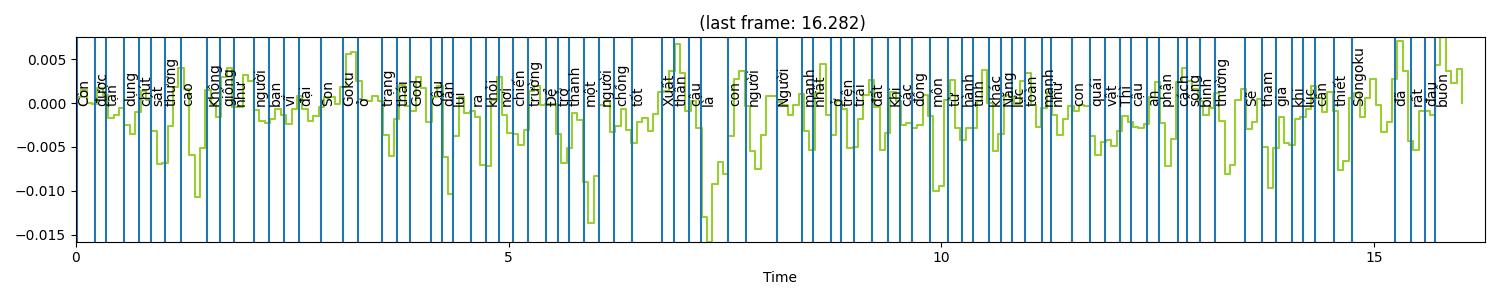

In [38]:
class AudioPlayer:
    """
    Player implemented with PyAudio
    http://people.csail.mit.edu/hubert/pyaudio/
    Mac OS X:
      brew install portaudio
      pip install http://people.csail.mit.edu/hubert/pyaudio/packages/pyaudio-0.2.8.tar.gz
    """
    def __init__(self, wav):
        self.p = pyaudio.PyAudio()
        self.pos = 0
        self.stream = None
        self._open(wav)

    def callback(self, in_data, frame_count, time_info, status):
        data = self.wf.readframes(frame_count)
        self.pos += frame_count
        return (data, pyaudio.paContinue)

    def _open(self, wav):
        self.wf = wave.open(wav, 'rb')
        self.stream = self.p.open(format=self.p.get_format_from_width(self.wf.getsampwidth()),
                channels = self.wf.getnchannels(),
                rate = self.wf.getframerate(),
                output=True,
                stream_callback=self.callback)
        self.pause()

    def play(self):
        self.stream.start_stream()

    def pause(self):
        self.stream.stop_stream()

    def seek(self, seconds = 0.0):
        sec = seconds * self.wf.getframerate()
        self.pos = int(sec)
        self.wf.setpos(int(sec))

    def time(self):
        return float(self.pos)/self.wf.getframerate()

    def playing(self):
        return self.stream.is_active()

    def close(self):
        self.stream.close()
        self.wf.close()
        self.p.terminate()


class PlotDiar:
    """
    A viewer of segmentation
    """
    def __init__(self, fileName, df, result_path='./result', gui=False, pick=False, vgrid=False, size=(18, 9)):
        self.rect_picked = None
        self.rect_color = (0.0, 0.6, 1.0, 1.0)  # '#0099FF'
        self.rect_selected_color = (0.75, 0.75, 0, 1.0)  # 'y'
        self.cluster_colors = [(0.0, 0.6, 1.0, 1.0), (0.0, 1.0, 0.6, 1.0), (0.6, 0.0, 1.0, 1.0), 
                               (0.6, 1.0, 0.0, 1.0), (1.0, 0.0, 0.6, 1.0), (1.0, 0.6, 0.0, 1.0)]

        plt.rcParams['keymap.fullscreen'] = 'ctrl+f'
        plt.rcParams['keymap.home'] = ''
        plt.rcParams['keymap.back'] = ''
        plt.rcParams['keymap.forward'] = ''
        plt.rcParams['keymap.pan'] = ''
        plt.rcParams['keymap.zoom'] = 'ctrl+z'
        plt.rcParams['keymap.quit'] = 'ctrl+q'
        plt.rcParams['keymap.grid'] = ''
        plt.rcParams['keymap.yscale'] = ''
        plt.rcParams['keymap.xscale'] = ''
        # plt.rcParams['keymap.all_axes'] = ''
        plt.rcParams['toolbar'] = 'None'
        plt.rcParams['keymap.save'] = 'ctrl+s'
        # plt.rcParams.update({'font.family': 'courrier'})

        self.pick = pick
        self.gui = gui
        self.vgrid = vgrid
        self.fig = plt.figure(figsize=size, facecolor='white', tight_layout=True)
        self.result_path = f'{result_path}/{fileName}.json'
        self.plot=plt

        self.ax = self.fig.add_subplot(1, 1, 1)
        cids = list()
        if self.gui:
            cids.append(
                self.fig.canvas.mpl_connect('key_press_event', self._on_keypress))
            cids.append(
                self.fig.canvas.mpl_connect('button_press_event', self._on_click))
            if pick:
                cids.append(self.fig.canvas.mpl_connect('pick_event', self._on_pick))
        self.height = 5
        self.maxx = 0
        self.maxy = 0
        self.end_play = 0
        df = df[df.fileName==fileName].reset_index(drop=True)
        self.wav = df.loc[0, 'audioPath']
        self.sr = librosa.get_duration(filename=self.wav)
        
        self.audio = None
        if self.wav is not None and self.gui:
            self.audio = AudioPlayer(self.wav)
            self.timer = self.fig.canvas.new_timer(interval=10)
            self.timer.add_callback(self._update_timeline)
            self.timer.start()

        self.timeline = self.ax.plot([0, 0], [0, 0], color='r')[-1]
        self.time_stamp = list()
        self.time_stamp_idx = 0

    def _draw_timeline(self, t):
        """
        Draw the timeline a position t
        :param t: in second, a float
        """
        min, max = self.ax.get_ylim()
        self.timeline.set_data([t, t], [min, max])
        self._draw_info(t)

    def _update_timeline(self):
        """
        Update the timeline given the position in the audio player
        """
        if self.audio is not None and self.audio.playing():
            t = self.audio.time()
            min, max = self.ax.get_xlim()
            if t > self.end_play and self.rect_picked is not None:
                self.audio.pause()
                self.end_play = self.maxx
            self._draw_timeline(t)
            if t > max:
                self._dec_right(min, max)
            if t < min:
                self._dec_left(min, max)
            self.fig.canvas.draw()

    def _draw_info(self, title=''):
        self.ax.set_title(title)

    def draw(self):
        """
        Draw the segmentation
        """
        with open(self.result_path, 'rb') as f:
            result = json.load(f)
        audio = librosa.load(self.wav, sr=self.sr)[0]
        waveshow(audio, color='yellowgreen', sr=self.sr, ax=self.ax)
        for line in result:
            list_word = line['l']
            for words in list_word:
                start_word, end_word, word = words['s']/1000, words['e']/1000, words['d']
                self.time_stamp.extend([start_word, end_word])
                self.maxx = max(self.maxx, end_word)
                self.ax.axvline(x=start_word)
                self.ax.text(start_word, 0, word, rotation=90, size=10)
        
        plt.xlim([0, self.maxx])
        plt.ylim([audio.min(), audio.max()])

        self.maxy = self.height
        self.end_play = self.maxx
        plt.title(' (last frame: ' + str(self.maxx) + ')')

        plt.tight_layout()
        self.time_stamp = list(set(self.time_stamp))
        self.time_stamp.sort()

        if self.vgrid:
            for x in  self.time_stamp:
                self.ax.plot([x, x], [0, self.maxy], linestyle=':', color='#AAAAAA')


    def _dec_right(self, min, max):
        """
        Move right
        :param min: a float
        :param max: a float
        """
        dec = (max - min) // 10
        diff = max - min
        if max + dec <= self.maxx:
            # print('** 1 ', min, max, dec)
            plt.xlim(min + dec, max + dec)
        else:
            # print('** 2 ', min, max, dec, diff)
            plt.xlim(self.maxx - diff, self.maxx)

    def _dec_left(self, min, max):
        """
        Move left
        :param min: a float
        :param max: a float
        """
        dec = (max - min) // 10
        diff = max - min
        if min - dec >= 0:
            plt.xlim(min - dec, max - dec)
        else:
            plt.xlim(0, diff)

    def _on_keypress(self, event):
        """
        manage the keypress event
        :param event: a key event
        """
        hmin, hmax = self.ax.get_xlim()
        diff = hmax - hmin
        if event.key == 'ctrl++' or event.key == 'ctrl+=':
            plt.xlim(hmin * 1.5, hmax * 1.5)
        elif event.key == 'ctrl+-':
            plt.xlim(hmin / 1.5, hmax / 1.5)
        elif event.key == 'escape':
            plt.xlim(0, self.maxx)
            plt.ylim(0, self.maxy)
        elif event.key == 'right':
            self._dec_right(hmin, hmax)
        elif event.key == 'left':
            self._dec_left(hmin, hmax)
        elif event.key == 'ctrl+right':
            plt.xlim(self.maxx - diff, self.maxx)
        elif event.key == 'ctrl+left':
            plt.xlim(0, diff)
        elif event.key == 'alt+right':
            self.time_stamp_idx = min(len(self.time_stamp)-1, self.time_stamp_idx + 1)
            if self.audio is not None:
                self.audio.pause()
                self.audio.seek(self.time_stamp[self.time_stamp_idx])
            self._draw_timeline(self.time_stamp[self.time_stamp_idx])
        elif event.key == 'alt+left':
            self.time_stamp_idx = max(0, self.time_stamp_idx - 1)
            if self.audio is not None:
                self.audio.pause()
                self.audio.seek(self.time_stamp[self.time_stamp_idx])
            self._draw_timeline(self.time_stamp[self.time_stamp_idx])
        elif event.key is None and self.audio is not None:
            self.audio.play()
        elif event.key == ' ' and self.audio is not None:
            if(self.audio.playing()):
                self.audio.pause()
            else:
                self.audio.play()

        self.fig.canvas.draw()

    def _on_click(self, event):
        """
        manage the mouse event
        :param event: a mouse event
        """
        if event.xdata is not None and self.rect_picked is None:
            if self.audio is not None:
                self.audio.pause()
                self.audio.seek(event.xdata)
            self._draw_timeline(event.xdata)
            self.fig.canvas.draw()

    def _on_pick(self, event):
        """
        manage the selection of a segment
        :param event: a picked event
        """
        if isinstance(event.artist, Rectangle) and event.mouseevent.dblclick:
            print('on pick dbclick')
            rect = event.artist
            x, y = rect.get_xy()
            w = rect.get_width()
            c = rect.get_fc()
            if self.rect_picked is not None:
                if self._colors_are_equal(c, self.rect_selected_color):
                    rect.set_color(self.rect_color)
                    self.rect_picked = None
                    self.end_play = self.maxx
                else:
                    self.rect_picked.set_color(self.rect_color)
                    rect.set_color(self.rect_selected_color)
                    self.rect_picked = rect
                    if self.audio is not None:
                        self.audio.pause()
                        self.audio.seek(x)
                    self.time_stamp_idx = self.time_stamp.index(x)
                    self.end_play = x + w
                    self._draw_timeline(x)
            else:
                rect.set_color(self.rect_selected_color)
                self.rect_picked = rect

                if self.audio is not None:
                    self.audio.pause()
                    self.audio.seek(x)
                self.time_stamp_idx = self.time_stamp.index(x)
                self.end_play = x + w
                self._draw_timeline(x)

            self.fig.canvas.draw()


    @classmethod
    def _colors_are_equal(cls, c1, c2):
        """
        Compare two colors
        """
        for i in range(4):
            if c1[i] != c2[i]:
                return False
        return True

    @classmethod
    def _hms(cls, s):
        """
        conversion of seconds into hours, minutes and secondes
        :param s:
        :return: int, int, float
        """
        h = int(s) // 3600
        s %= 3600
        m = int(s) // 60
        s %= 60
        return '{:d}:{:d}:{:.2f}'.format(h, m, s)

    # def 

idx = 13
p = PlotDiar(fileName=private_df.loc[idx, 'fileName'], df=private_df, gui=True, size=(15,3))
p.draw()
p.plot.show()